In [226]:
using Plots
using Dates
using StatsBase
using DataFrames
using Tables

include("../code/KFactors.jl")
include("../code/KFactorPeaks.jl")
using .KFactors
using .KFactorPeaks

In [192]:
data = read_data("../data/all_district_peaks.parquet", "../data/sensor_meta_geo.csv");

┌ Info: Observations in each period
│   combine(groupby(data, :period), nrow) = 3×2 DataFrame
 Row │ period        nrow    
     │ Cat…          Int64   
─────┼───────────────────────
   1 │ pandemic       365083
   2 │ postpandemic   338894
   3 │ prepandemic   1371886
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:92
┌ Info: Before filtering, data has 2075863 rows
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:103
┌ Info: Removing sensors days with peak-hour occ above 99th percentile (0.22%)
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:131
┌ Info: After filtering, data has 961571 rows
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:135


In [193]:
# https://identity.unc.edu/brand/color-palette/
const UNC_BLUE = RGB(75/255, 156/255, 211/255)
const UNC_NAVY = RGB(19/255, 41/255, 75/255)
const UNC_DAVIE_GREEN = RGB(196/255, 214/255, 0/255)
const UNC_PINK = RGB(239/255, 68/255, 111/255);

In [216]:
names(data)

23-element Vector{String}:
 "station"
 "peak_hour_occ"
 "peak_hour_flow"
 "occ_entropy"
 "total_occ"
 "total_flow"
 "station_type"
 "freeway_number"
 "periods_imputed"
 "longest_imputed_time"
 "direction"
 "day_of_week"
 "District"
 "urban"
 "Lanes"
 "Latitude"
 "Longitude"
 "date"
 "peak_hour_start"
 "peak_flow_start"
 "period"
 "dayofweek"
 "present_in_all_periods"

In [217]:
med_start = combine(groupby(data, [:period, :station]), :peak_hour_start => (x -> percentile(x, 50)) => :peak_hour_start,
    :Latitude => first => :Latitude,
    :Longitude => first => :Longitude,
    :District => first => :District,
    :direction => first => :direction
    );

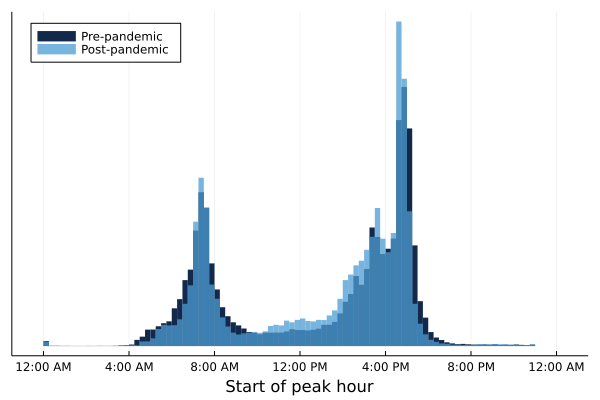

In [166]:
breaks = range(0, 24 * 60 * 60 * 1000 * 1000 * 1000, length = 24 * 4 + 1)
histogram(Dates.value.(skipmissing(data.peak_hour_start[data.period .== "prepandemic"])),
    color=UNC_NAVY, label="Pre-pandemic", normalize=true, legend=:topleft, bins=breaks, lw=0)
histogram!(Dates.value.(skipmissing(data.peak_hour_start[data.period .== "postpandemic"])),
    color=UNC_BLUE, lw=0, label="Post-pandemic", normalize=true, alpha=0.75, bins=breaks)
plot!(xformatter=x -> Dates.format((Dates.Time ∘ Dates.Nanosecond)(x), "I:MM p"), xticks=breaks[1:16:end], yticks=false, xlabel="Start of peak hour")

In [221]:
data.direction

961571-element Vector{Union{Missing, String}}:
 "W"
 "E"
 "W"
 "S"
 "N"
 "E"
 "W"
 "W"
 "N"
 "N"
 "S"
 "N"
 "N"
 ⋮
 "S"
 "N"
 "S"
 "N"
 "N"
 "N"
 "N"
 "S"
 "N"
 "S"
 "S"
 "N"

In [248]:
function getquiver(d, coslat, offset)
    u = map(Tables.rows(d)) do row
        if row.direction == "E"
            offset
        elseif row.direction == "W"
            -offset
        else
            0
        end
    end
    
    v = map(Tables.rows(d)) do row
        if row.direction == "N"
            offset
        elseif row.direction == "S"
            -offset
        else
            0
        end
    end
        
    u, v
end

function animpeaks(d, annotations...)
    coslat = cosd(mean(d.Latitude))
    @animate for t in Dates.Time(0):Dates.Minute(5):Dates.Time(23, 59, 59)
        peak = d[d.peak_hour_start .> t - Dates.Hour(1) .&& d.peak_hour_start .≤ t, :]
        scatter(d.Longitude, d.Latitude, color=:blue, markersize=3, aspect_ratio=coslat)
        quiver!(peak.Longitude, peak.Latitude, quiver=getquiver(peak, coslat, 0.001), color=:red, markersize=1, label="peak")
        annotate!((minimum(d.Longitude), minimum(d.Latitude), "$t"))
        annotate!.(annotations)
    end
end

animpeaks (generic function with 2 methods)

┌ Info: Saved animation to 
│   fn = /Users/mwbc/git/peak-spreading/presentation/peaks_bayarea.gif
└ @ Plots /Users/mwbc/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/Users/mwbc/git/peak-spreading/presentation/peaks_bayarea.gif")
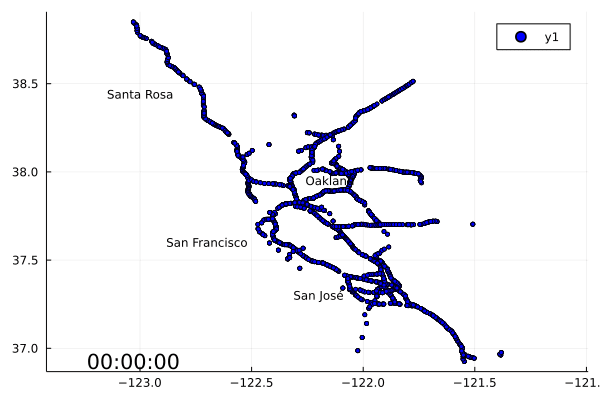

In [254]:
gif(animpeaks(med_start[med_start.District .== 4, :],
    (-122.7, 37.6, text("San Francisco", pointsize=8)),
    (-122.2, 37.3, text("San José", pointsize=8)),
    (-122.15, 37.95, text("Oakland", pointsize=8)),
    (-123, 38.44, text("Santa Rosa", pointsize=8))
), "../presentation/peaks_bayarea.gif")

┌ Info: Saved animation to 
│   fn = /Users/mwbc/git/peak-spreading/presentation/peaks_la.gif
└ @ Plots /Users/mwbc/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/Users/mwbc/git/peak-spreading/presentation/peaks_la.gif")
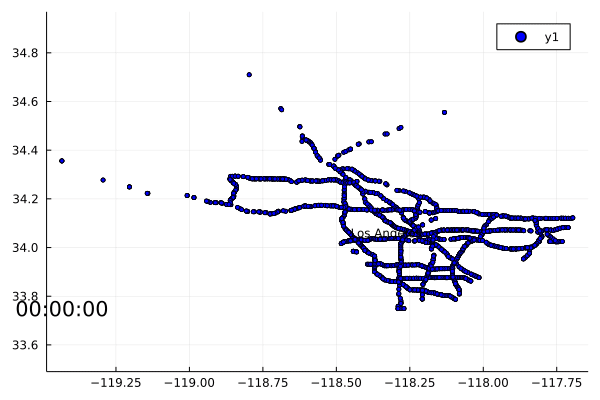

In [253]:
gif(animpeaks(med_start[med_start.District .== 7, :],
        (-118.33, 34.06, text("Los Angeles", pointsize=8))), "../presentation/peaks_la.gif")


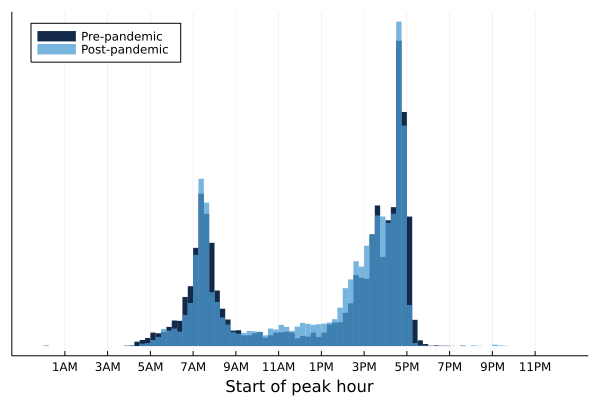

In [263]:
breaks = range(0, 24 * 60 * 60 * 1000 * 1000 * 1000, length = 24 * 4 + 1)
histogram(Dates.value.(med_start.peak_hour_start[med_start.period .== "prepandemic"]),
    color=UNC_NAVY, label="Pre-pandemic", normalize=true, legend=:topleft, bins=breaks, lw=0, dpi=600)
histogram!(Dates.value.(med_start.peak_hour_start[med_start.period .== "postpandemic"]),
    color=UNC_BLUE, lw=0, label="Post-pandemic", normalize=true, alpha=0.75, bins=breaks)
plot!(xformatter=x -> Dates.format((Dates.Time ∘ Dates.Nanosecond)(x), "Ip"), xticks=breaks[5:8:end], yticks=false, xlabel="Start of peak hour")
savefig("../presentation/peak_starts.png")
plot!()

## Something seems fishy

I would expect more morning than evening peaks. Spot check.

In [97]:
day = KFactorPeaks.read_day_file("/Volumes/Pheasant Ridge/pems/d04_text_station_5min_2017_06_21.txt.gz")

,timestamp,station,district,freeway_number,direction,lane_type,station_len
,DateTime,Int64,Int64,Int64,String,String,Float64?
1,2017-06-21T00:00:00,400000,4,101,S,ML,0.415
2,2017-06-21T00:00:00,400001,4,101,N,ML,0.265
3,2017-06-21T00:00:00,400002,4,101,S,ML,0.31
4,2017-06-21T00:00:00,400006,4,880,S,ML,0.34
5,2017-06-21T00:00:00,400007,4,101,N,ML,0.365
6,2017-06-21T00:00:00,400009,4,80,W,ML,0.321
7,2017-06-21T00:00:00,400010,4,101,N,ML,0.47
8,2017-06-21T00:00:00,400011,4,101,S,ML,0.225
9,2017-06-21T00:00:00,400014,4,101,N,ML,0.29


In [121]:
names(data)

LoadError: UndefVarError: datA not defined

In [186]:
function osm_station(station)
    ll = data[data.station .== station, [:Latitude, :Longitude]][1, :]
    println("https://www.openstreetmap.org/search?query=$(ll.Latitude)%2C%20$(ll.Longitude)#map=18/$(ll.Longitude)/$(ll.Latitude)")
end

osm_station (generic function with 1 method)

In [187]:
function check_station(station_number)
    obs = data[(data.station .== station_number) .&& (data.date .== Date(2017, 6, 21)), [:peak_hour_start, :peak_hour_occ]][1, :]
    occ = day[(day.station .== station_number), [:time, :avg_occ]]
    osm_station(station_number)
    # recalc peak occ
    sel = occ.time .≥ obs.peak_hour_start .&& occ.time .< obs.peak_hour_start + Dates.Hour(1)
    @assert sum(sel) == 12
    peak_occ = sum(occ[sel, :avg_occ]) / sum(occ.avg_occ)
    peak_occ ≈ obs.peak_hour_occ || println("$peak_occ != $(obs.peak_hour_occ)")
    bar(occ.time, occ.avg_occ, lw=0)
    vspan!([obs.peak_hour_start, obs.peak_hour_start + Dates.Hour(1)], color=:red, alpha=0.35)
end

check_station (generic function with 1 method)

https://www.openstreetmap.org/search?query=37.335259%2C%20-121.848031#map=18/-121.848031/37.335259


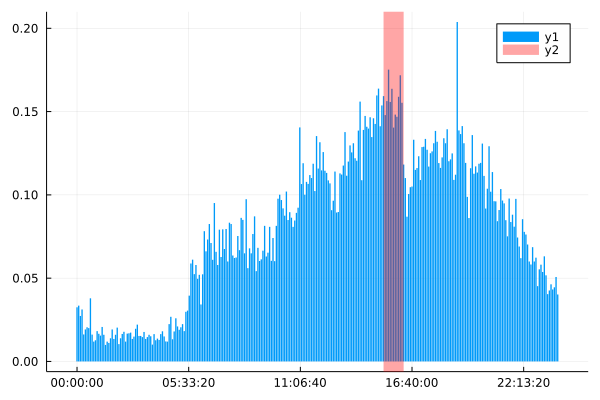

In [188]:
check_station(401906)